# 1. Projekat iz predmeta Mašinsko učenje

Eye State Classification - EEG
https://www.kaggle.com/datasets/robikscube/eye-state-classification-eeg-dataset/data

Marija Cvetković 1940

Luka Kocić 2022

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold


In [3]:
df = pd.read_csv("input-eeg.csv")

## 1. Analiza podataka

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [27]:
df.describe()

AF3            F7            F3            FC5            T7  \
count   14980.000000  14980.000000  14980.000000   14980.000000  14980.000000   
mean     4321.917777   4009.767694   4264.022433    4164.946326   4341.741075   
std      2492.072174     45.941672     44.428052    5216.404632     34.738821   
min      1030.770000   2830.770000   1040.000000    2453.330000   2089.740000   
25%      4280.510000   3990.770000   4250.260000    4108.210000   4331.790000   
50%      4294.360000   4005.640000   4262.560000    4120.510000   4338.970000   
75%      4311.790000   4023.080000   4270.770000    4132.310000   4347.180000   
max    309231.000000   7804.620000   6880.510000  642564.000000   6474.360000   

                  P7             O1            O2             P8  \
count   14980.000000   14980.000000  14980.000000   14980.000000   
mean     4644.022379    4110.400160   4616.056904    4218.826610   
std      2924.789537    4600.926543     29.292603    2136.408523   
min      2768.210000    2086.150000   4567.180000    1357.950000   
25%      4611.790000    4057.950000   4604.620000    4190.770000   
50%      4617.950000    4070.260000   4613.330000    4199.490000   
75%      4626.670000    4083.590000   4624.100000    4209.230000   
max    362564.000000  567179.000000   7264.100000  265641.000000   

                 T8           FC6            F4             F8            AF4  \
count  14980.000000  14980.000000  14980.000000   14980.000000   14980.000000   
mean    4231.316200   4202.456900   4279.232774    4615.205336    4416.435832   
std       38.050903     37.785981     41.544312    1208.369958    5891.285043   
min     1816.410000   3273.330000   2257.950000      86.666700    1366.150000   
25%     4220.510000   4190.260000   4267.690000    4590.770000    4342.050000   
50%     4229.230000   4200.510000   4276.920000    4603.080000    4354.870000   
75%     4239.490000   4211.280000   4287.180000    4617.440000    4372.820000   
max     6674.360000   6823.080000   7002.560000  152308.000000  715897.000000   

       eyeDetection  
count  14980.000000  
mean       0.448798  
std        0.497388  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [28]:
df['eyeDetection'].value_counts()

eyeDetection
0    8257
1    6723
Name: count, dtype: int64

Da bismo razumeli kako da izaberemo koje informacije želimo da uključimo u treniranje našeg model treba da znamo osnovne stvari o kolona koje imamo.
Opisi kolona:
Svaki od ovih parametara je električni signal sa određene pozicije na glavi meren u vremenu.

1. AF3 i AF4 se nalaze kod obrva i izuzetno su osetljivi na pokrete očiju. Kada se oko zatvori ili trepne trebalo bi da signal pravi veliki pik
2. F7 i F8 blizu očiju, levo i desno.
3. F3 i F4 takođe blizu očiju, ali ne koliko i prethodna dva
4. FC5 i FC6 mešavina frontalne i centralne aktivnosti
5. T7 i T8 nalaze se sa strane glave i ne bi trebalo toliko da utiču na treptaje, nalaze se daleko
6. P7 i P8 su senzorni regioni
7. O1 i O2 direktno vezani za vid, tako da bi trebalo da jako utiču.

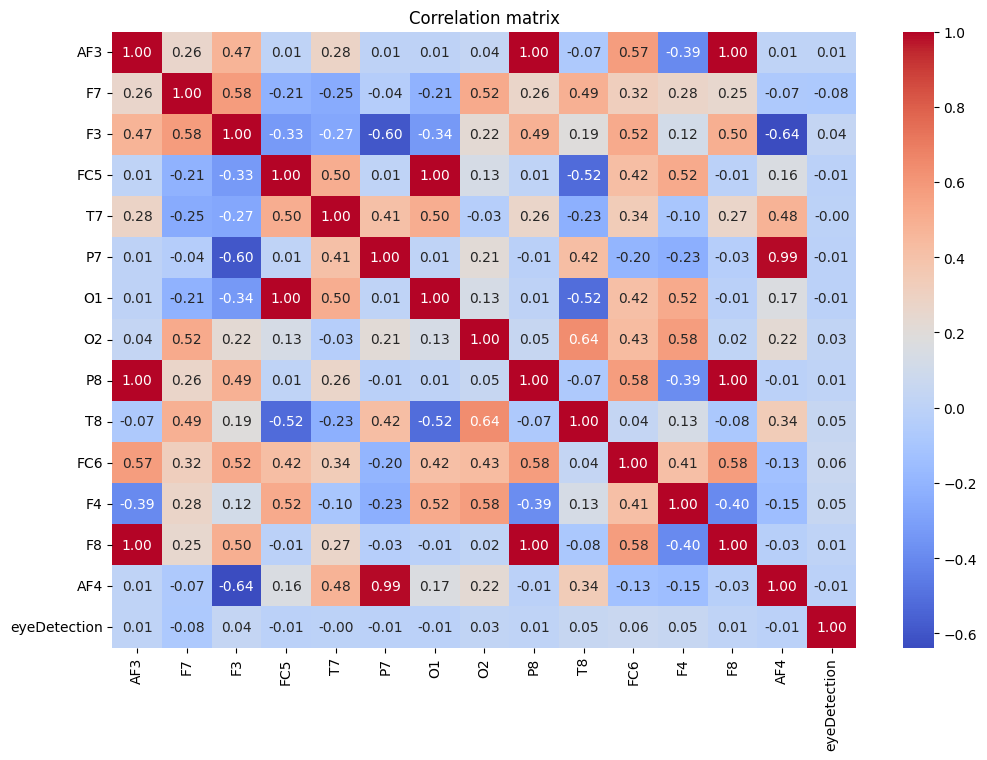

In [29]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation matrix")
plt.show()

Na osnovu matrice korelacije možemo da zaključimo sledeće:
1. EyeDetection kolona prema matrici korelacije trenutno nema linearnu vezu sa ostalim kanalima sve vrednosti su izmedju 0.00 i -0.06 (jer je eyeDetection boolean)

2. Postoje visoke korelacije izmedju AF3 i F8 (1.00), AF3 i P8 (1.00), P8 i F8(1.00), FC5 i O1 (1.00), PC8 i F8 (1.00)  kao i izmedju P7 i AF4(0.99). Imamo duplirane podatke što znači da model može da bude nestabilan. Možemo da izbacimo jednu kolonu iz svakog od navedenih parova.

Za izbor kolone za isključivanje biće korišćena point-beserial korelacija sa eyeDetection kolonom:

In [30]:
from scipy.stats import pointbiserialr

for col in df.select_dtypes(include='number'):
    corr, p_value = pointbiserialr(df["eyeDetection"], df[col])
    print(f"{col}: {abs(corr):.4f}")

AF3: 0.0105
F7: 0.0800
F3: 0.0389
FC5: 0.0075
T7: 0.0004
P7: 0.0078
O1: 0.0072
O2: 0.0251
P8: 0.0096
T8: 0.0472
FC6: 0.0643
F4: 0.0480
F8: 0.0131
AF4: 0.0075
eyeDetection: 1.0000


## 2. Deskriptivna analiza i čišćenje podataka

In [31]:
df.isnull().sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

In [32]:
df.duplicated().any()

np.False_

In [33]:
df = df.drop_duplicates()

### Detekcija outlier-a


Box plot nad svim numerickim podacima

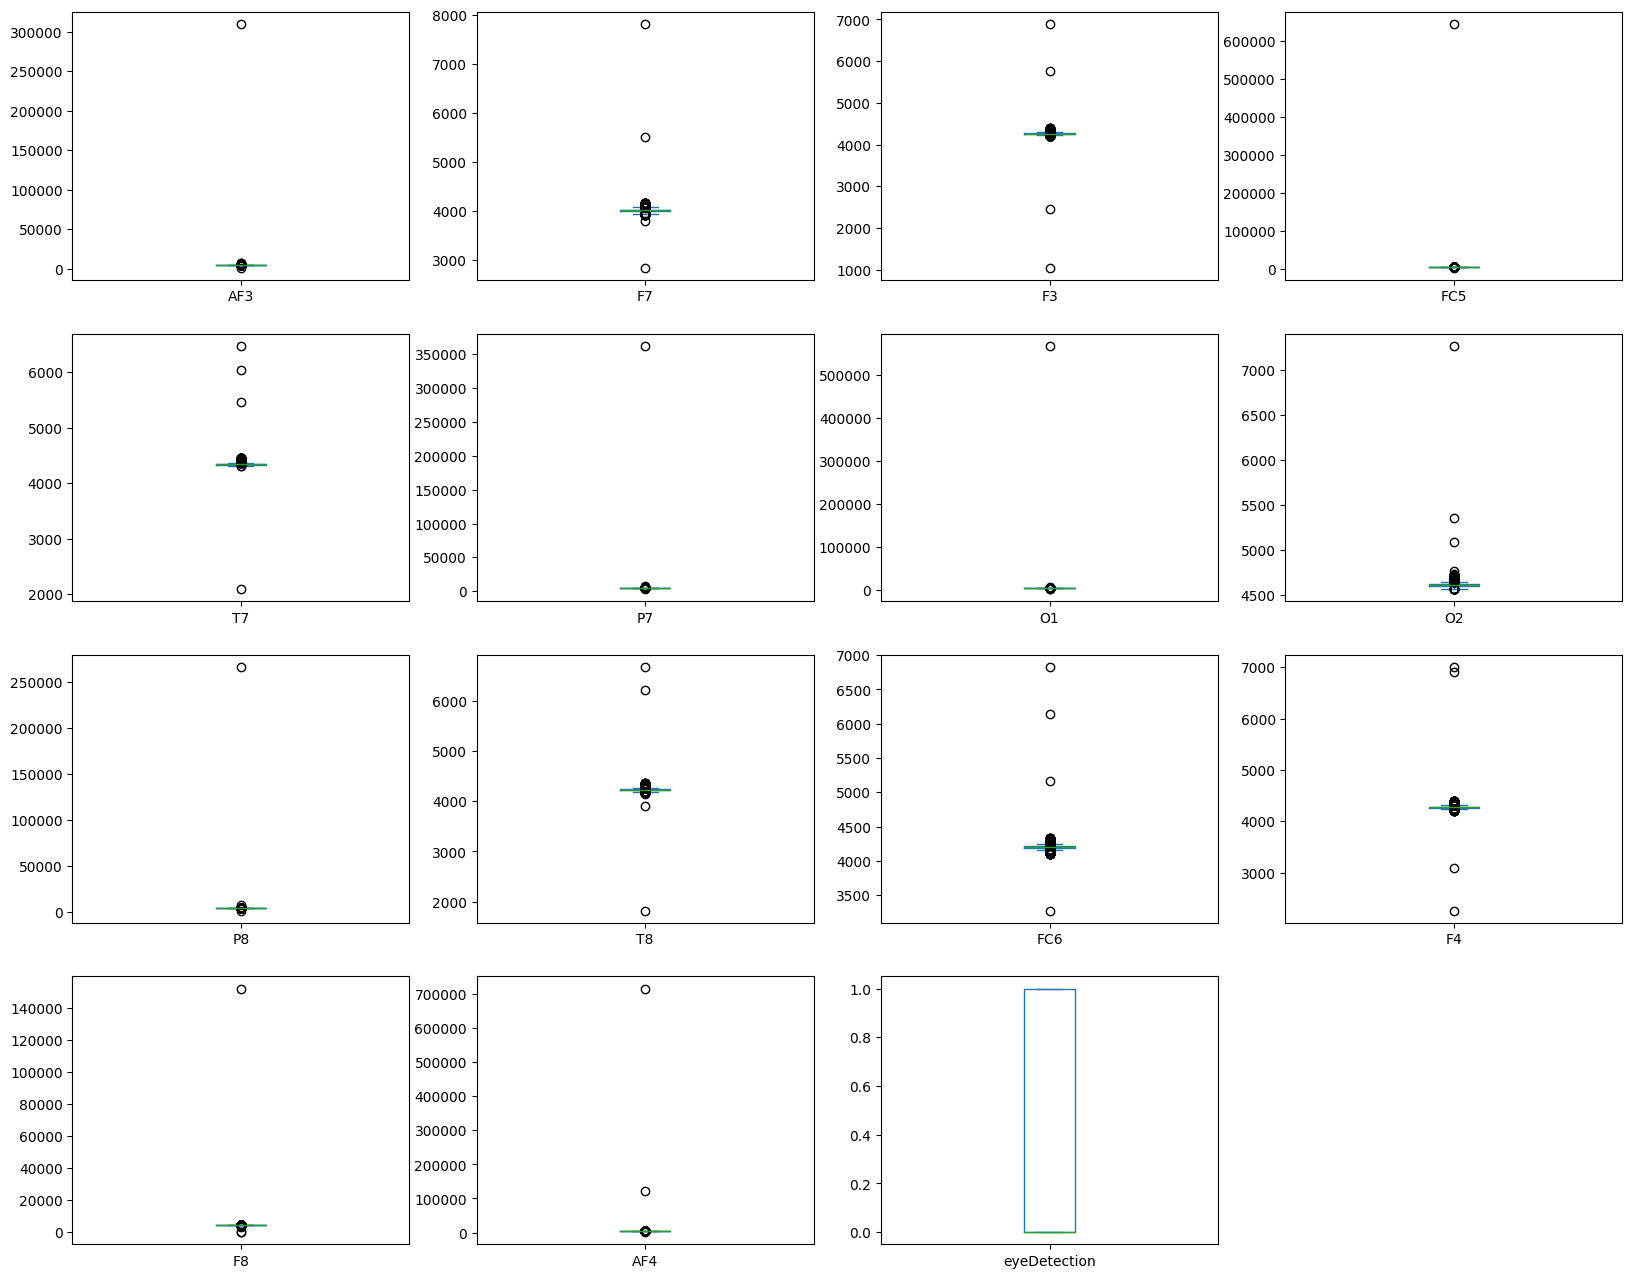

In [34]:
number_columns = df.select_dtypes(include='number')
number_columns.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,16))
plt.show()

Vizualizacija outlier-a pomoću boxplot-a, scatter plot-a i histograma:

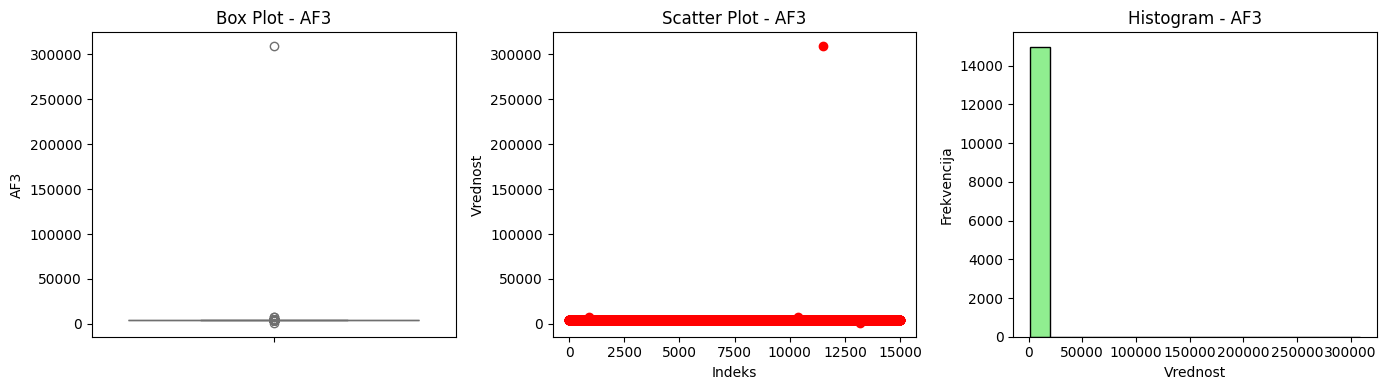

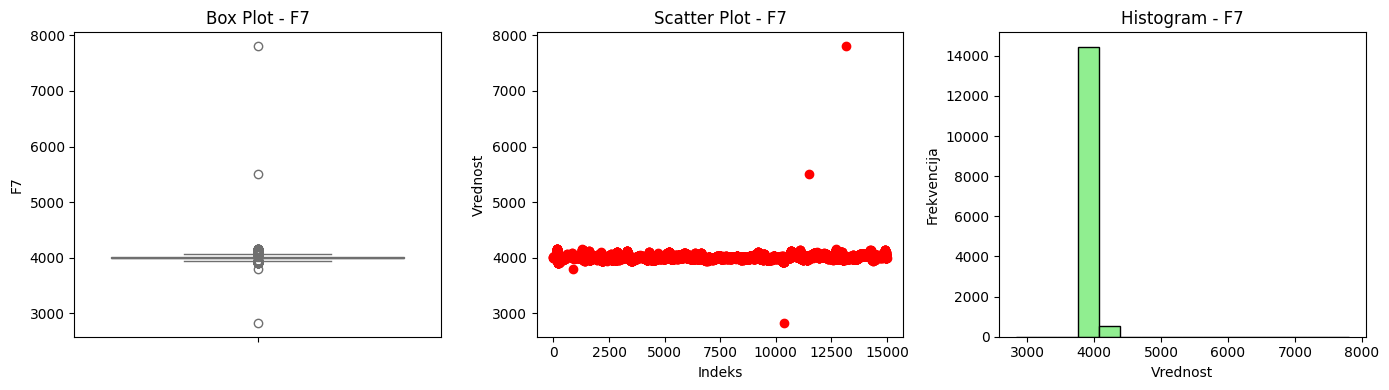

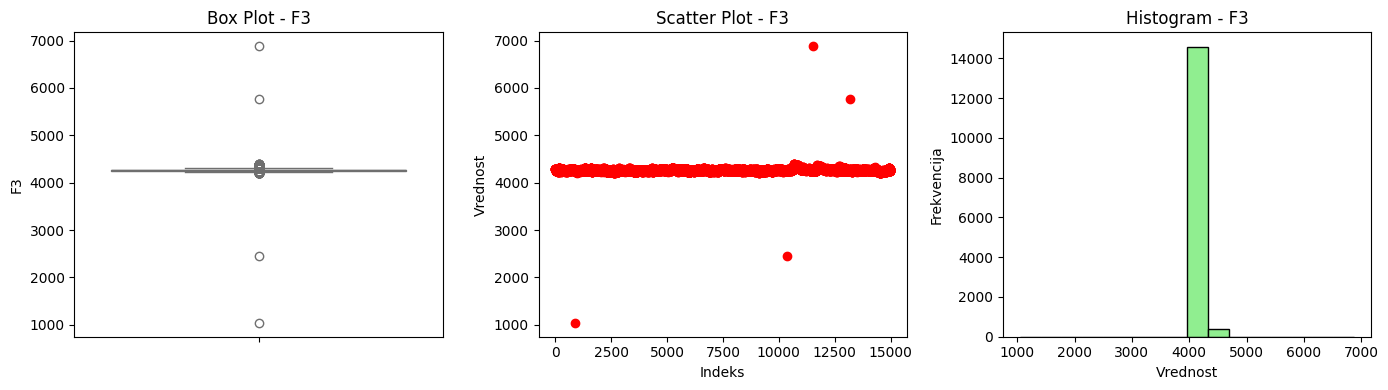

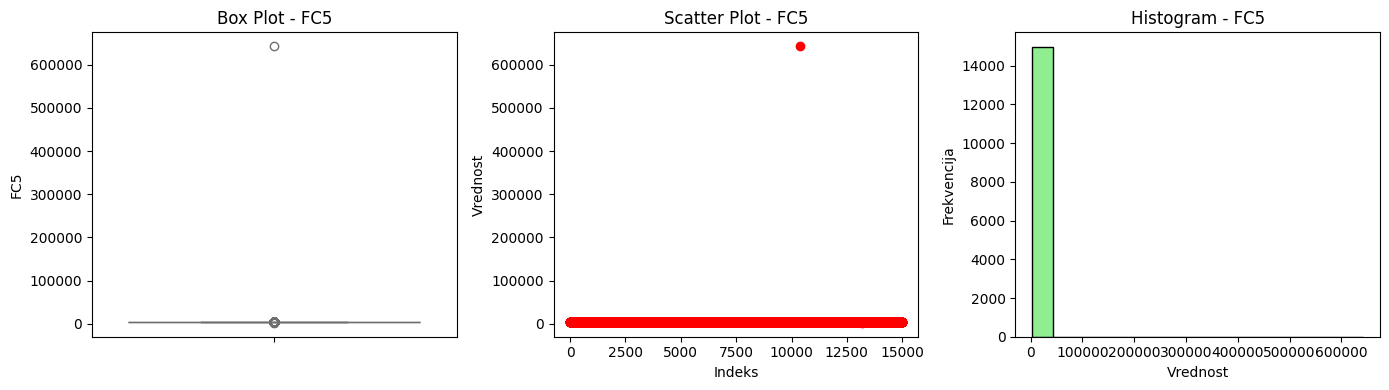

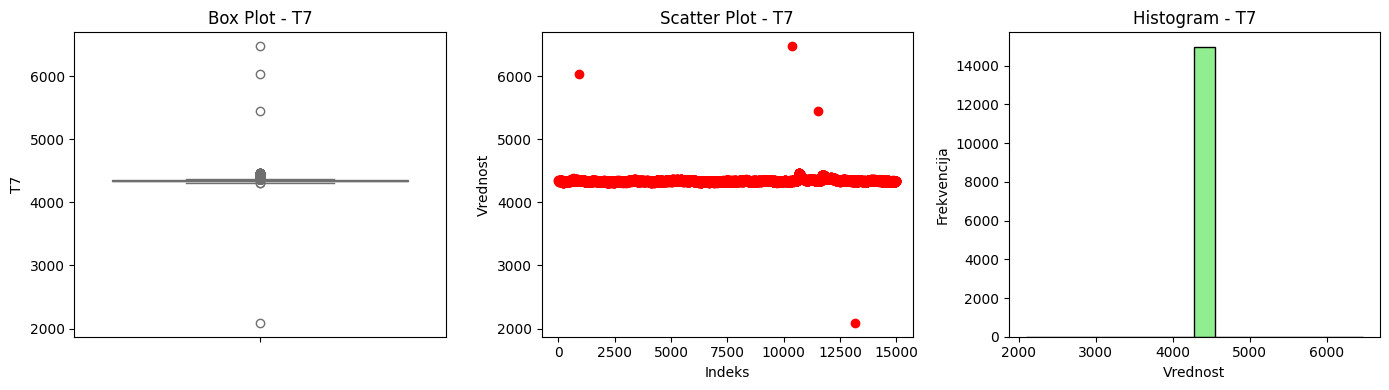

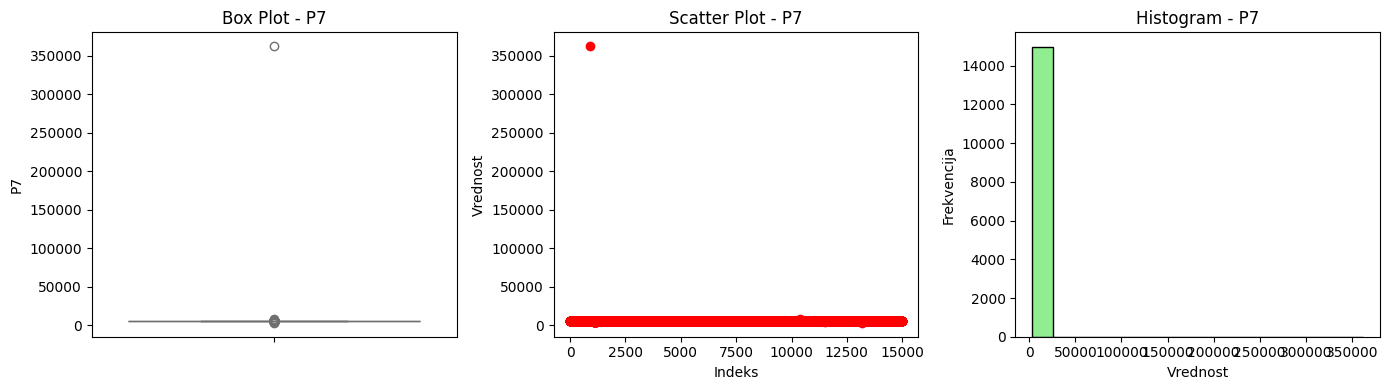

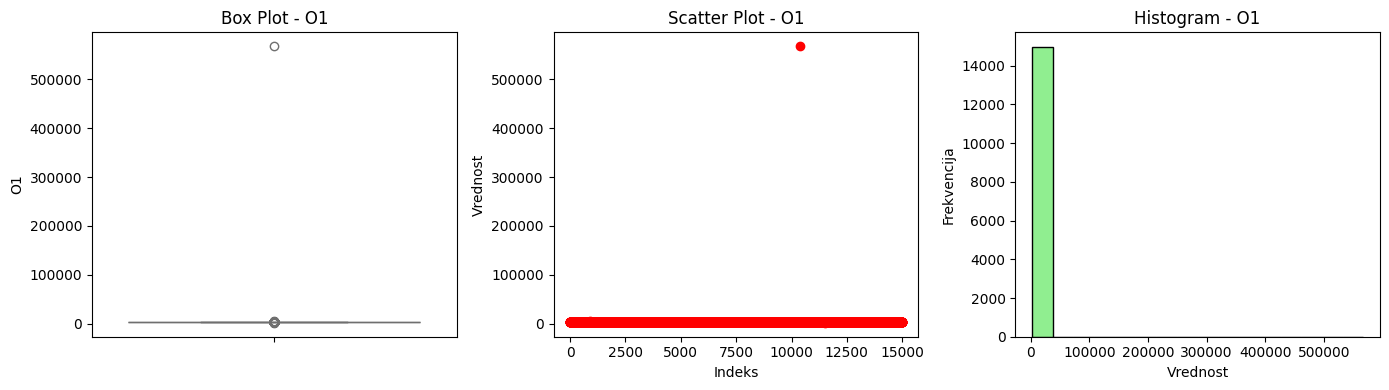

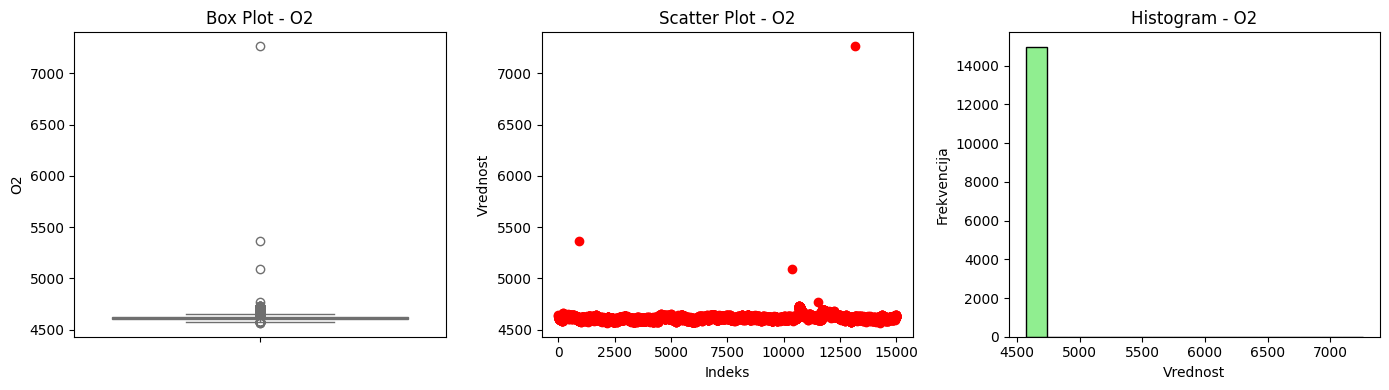

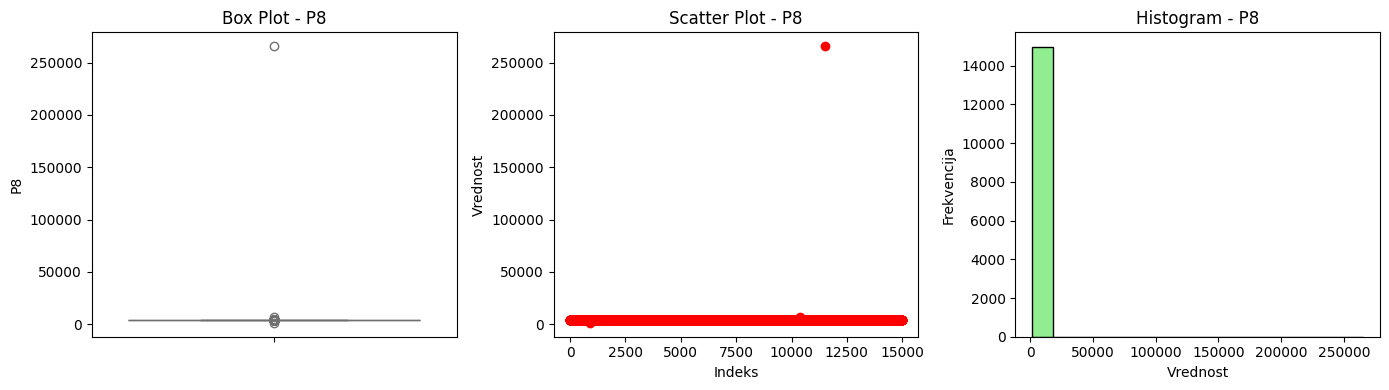

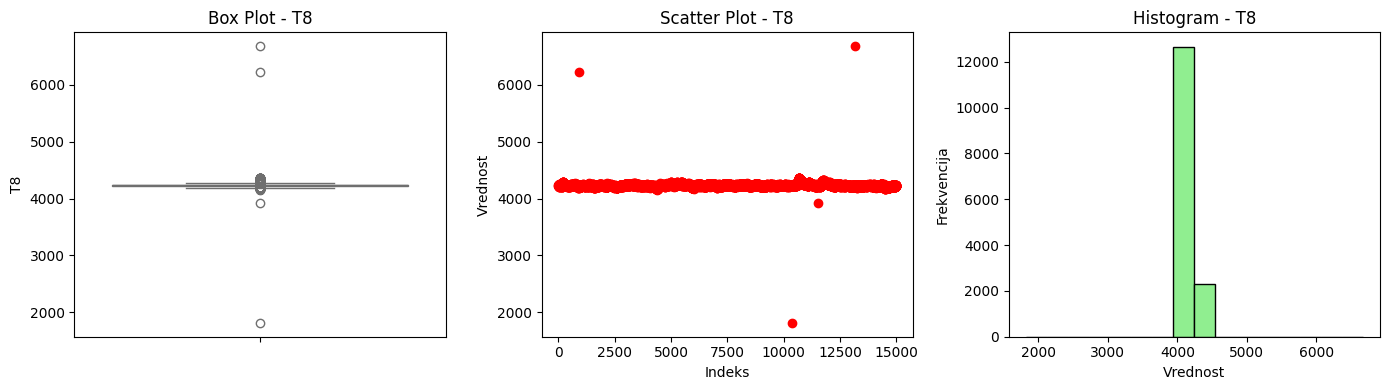

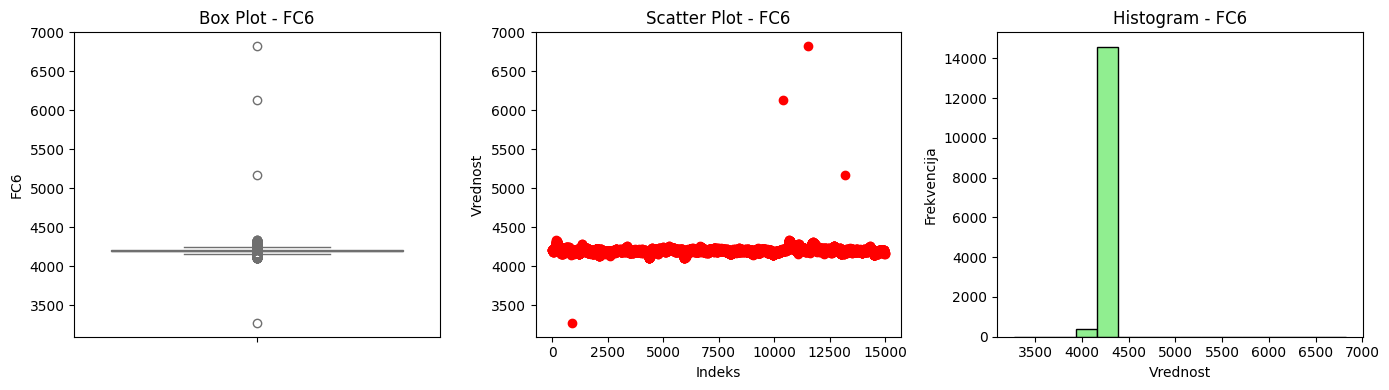

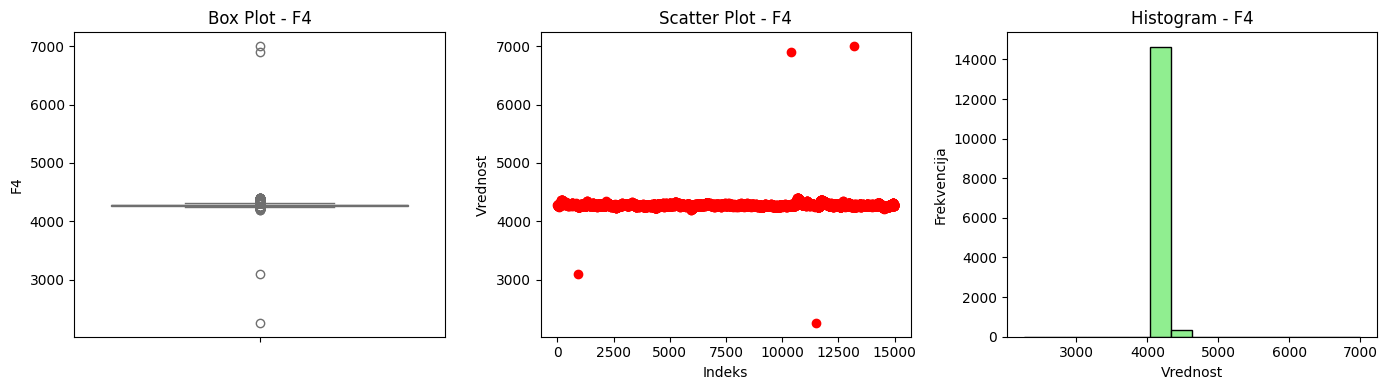

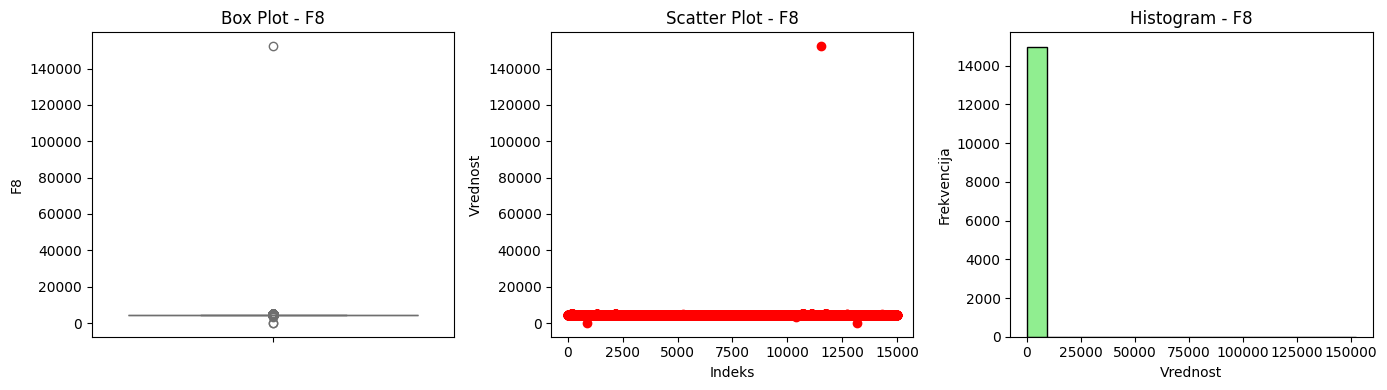

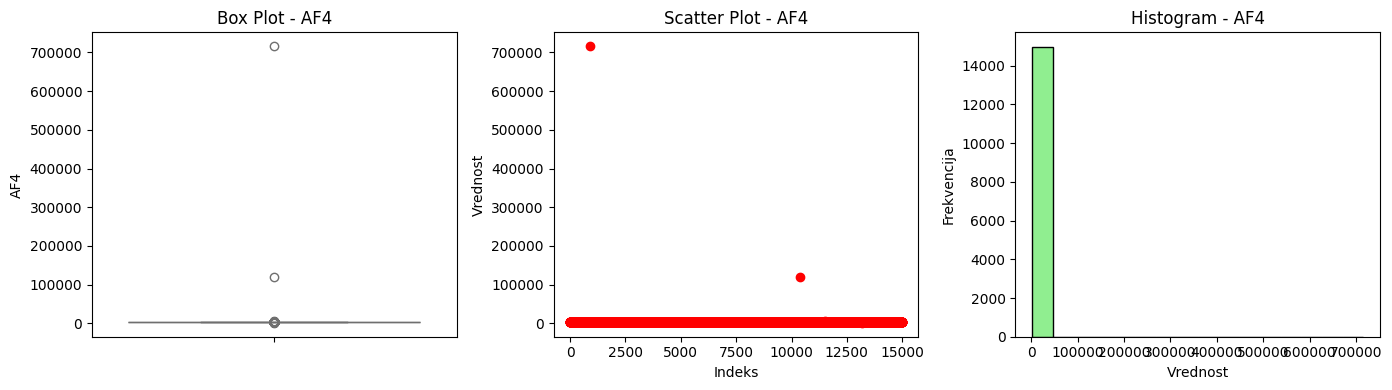

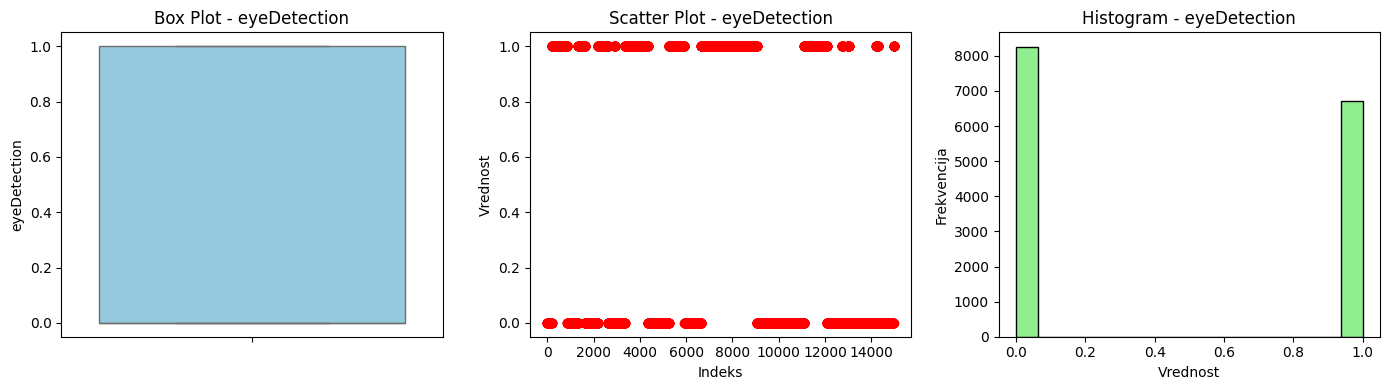

In [35]:
for column in number_columns.columns:
        plt.figure(figsize=(14, 4))
        
        # Box plot
        plt.subplot(1, 3, 1)
        sns.boxplot(y=df[column], color='skyblue')
        plt.title(f"Box Plot - {column}")
        
        # Scatter plot
        plt.subplot(1, 3, 2)
        plt.scatter(x=range(len(df)), y=df[column], color='red')
        plt.title(f"Scatter Plot - {column}")
        plt.xlabel("Indeks")
        plt.ylabel("Vrednost")
        
        # Histogram
        plt.subplot(1, 3, 3)
        plt.hist(df[column], bins=16, color='lightgreen', edgecolor='black')
        plt.title(f"Histogram - {column}")
        plt.xlabel("Vrednost")
        plt.ylabel("Frekvencija")
        
        plt.tight_layout()
        plt.show()

Primena IQR i Z_Score metode za detekciju outlier-a:

In [36]:
for column in number_columns.columns:
        print(f"\n--- Kolona: {column} ---")

        # IQR metoda
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        donja_granica = Q1 - 1.5 * IQR
        gornja_granica = Q3 + 1.5 * IQR
        outlieri_iqr = df[(df[column] < donja_granica) | (df[column] > gornja_granica)]
        print("Outlieri po IQR metodi:")
        print(outlieri_iqr)

        # Z-Score metoda
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        outlieri_zscore = df[(z_scores > 3) | (z_scores < -3)]
        print("Outlieri po Z-Score metodi:")
        print(outlieri_zscore)


--- Kolona: AF3 ---
Outlieri po IQR metodi:
           AF3       F7       F3      FC5       T7       P7       O1       O2  \
152    4375.38  4072.82  4263.08  4150.26  4337.95  4582.56  4056.92  4599.49   
153    4401.54  4090.26  4267.18  4156.41  4336.92  4586.15  4053.33  4598.97   
154    4412.31  4094.36  4262.56  4149.23  4332.31  4591.79  4057.44  4611.28   
155    4416.92  4106.67  4261.03  4153.33  4334.87  4589.23  4062.56  4604.62   
156    4430.26  4123.08  4268.21  4156.92  4336.92  4592.31  4069.74  4592.82   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14935  4397.95  4096.41  4296.92  4155.90  4331.79  4605.13  4063.08  4616.92   
14936  4389.74  4092.82  4287.69  4157.95  4335.38  4607.69  4062.05  4612.82   
14937  4385.13  4089.23  4279.49  4155.90  4334.36  4607.18  4056.92  4614.36   
14938  4374.36  4083.08  4280.00  4155.38  4331.28  4603.08  4053.85  4605.64   
14939  4362.05  4070.26  4280.51  4150.77  4332.31  4599.49  405

U primeru iznad smo detektovali da imamo outlier-e. Sledeći korak je da vidimo koja je najbolja metoda za njihovo otklanjanje. Prvo ćemo da vidimo koliko reodva ima najmanje jedan outliere, ako nije preveliki broj redova možemo ih samo izbrisati.

In [37]:
iqr_mask = pd.Series(False, index=df.index)
zscore_mask = pd.Series(False, index=df.index)

for column in number_columns.columns:
    # IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    donja = Q1 - 1.5 * IQR
    gornja = Q3 + 1.5 * IQR

    iqr_mask |= (df[column] < donja) | (df[column] > gornja)

    # Z-score
    std = df[column].std()
    if std != 0:
        z = (df[column] - df[column].mean()) / std
        zscore_mask |= (z > 3) | (z < -3)

print(f"Broj redova sa bar jednim IQR outlierom: {iqr_mask.sum()}")
print(f"Broj redova sa bar jednim Z-score outlierom: {zscore_mask.sum()}")


Broj redova sa bar jednim IQR outlierom: 3127
Broj redova sa bar jednim Z-score outlierom: 88


Veliki broj redova sadrži bar jedan outlier-e tako da odbacujemo opciju brisanja redova.

## 3. Transformacija podataka

## 4. Treniranje modela

### Podela podataka:

In [4]:
le = LabelEncoder()
y = df['eyeDetection']

X = df.drop(
    ['eyeDetection'],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11984, 14)
(2996, 14)
(11984,)
(2996,)


### Lazy Predict

In [39]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(
    verbose=0, 
    ignore_warnings=True, 
    custom_metric=None, 
    predictions=False,
)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5313, number of negative: 6671
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3553
[LightGBM] [Info] Number of data points in the train set: 11984, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443341 -> initscore=-0.227613
[LightGBM] [Info] Start training from score -0.227613
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.94               0.94     0.94      0.94   
XGBClassifier                      0.93               0.93     0.93      0.93   
RandomForestClassifier             0.92               0.92     0.92      0.92   
LGBMClassifier                     0.90               0.90     0.90      0.90   
BaggingClassifier     

Funkcija za izveštaj o performansama modela:

In [66]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def report(y_test, y_pred, title):
    acc = accuracy_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    return {
        "accuracy": acc,
        "classification_report": cr,  # dict forma
        "confusion_matrix": cm
    }

### Random Forest

In [67]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler


def run_random_forest_classifier(X_train, y_train, X_test, y_test, preprocessors):
    forest = RandomForestClassifier(random_state=42, n_jobs=1)
    pipe = make_pipeline(*preprocessors, forest)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    res = report(y_test, y_pred, "Random Forest Classifier")
    return res["accuracy"]

### Extra Trees Classifier

Radi slično kao Random Forest Classifier, ali u praksi ima veću preciznost. \
n_estimators - broj stabala

In [68]:
from sklearn.ensemble import ExtraTreesClassifier

def run_extra_trees_classifier(X_train, y_train, X_test, y_test, preprocessors):
    et_classifier = ExtraTreesClassifier(n_estimators=100, criterion='gini', random_state=42)

    pipe = make_pipeline(*preprocessors, et_classifier)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Extra Trees Classifier")
    return res["accuracy"]        

### K-Nearest Neighbours (KNN)

Lazy predictor \
K - broj najbiližih tačaka koje su uzimaju u obzir

In [69]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

def run_knn_classifier(X_train, y_train, X_test, y_test, preprocessors):
    pipe = make_pipeline(*preprocessors, KNeighborsClassifier())

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "K-Nearest Neighbour Classifier")
    return res["accuracy"]

### SVM

In [70]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def run_svm_classifier(X_train, y_train, X_test, y_test, preprocessors):
    pipe = make_pipeline(*preprocessors, SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "SVM Classifier")
    return res["accuracy"]

### Logisticka regresija



Pogodna je za binarnu klasifikaciju.

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

def run_logistic_regression_classifier(X_train, y_train, X_test, y_test, preprocessors):
    clf = LogisticRegression(
        n_jobs = 1
    )

    pipe = make_pipeline(*preprocessors, clf)

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Logistic Regression Classifier")
    return res["accuracy"]
    

### Naive Bayes

Naivna metoda - algoritam smatra da je svaki fature nekorelisan.

In [72]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold

def run_naive_bayes_classifier(X_train, y_train, X_test, y_test, preprocessors):
    pipe = make_pipeline(*preprocessors, GaussianNB())
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Naive Bayes Classifier")
    return res["accuracy"]

### Decision Tree Classifier

Kreiranje stabla odlučivanja na osnovu feature-a

In [74]:
from sklearn.tree import DecisionTreeClassifier

def run_decision_tree_classifier(X_train, y_train, X_test, y_test, preprocessors):
    clf = DecisionTreeClassifier(random_state=42)

    pipe = make_pipeline(*preprocessors, clf)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Decision Tree Classifier")
    return res["accuracy"]

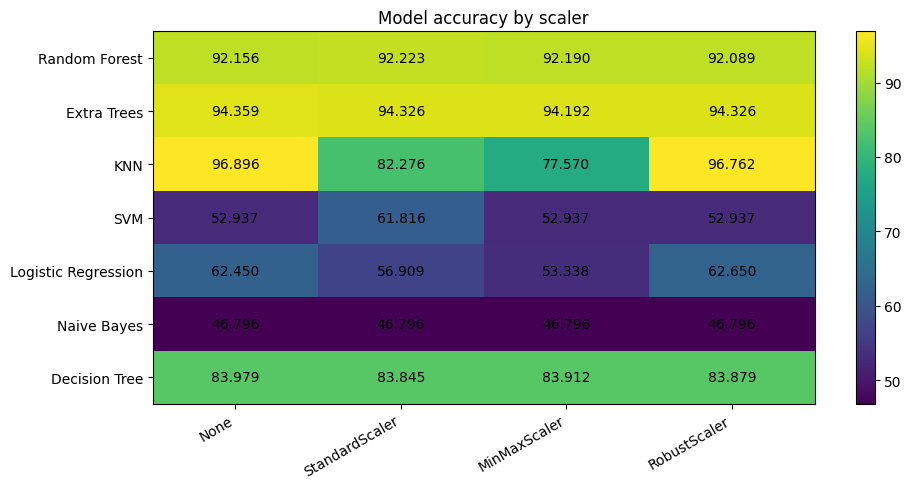

In [103]:
def run_classifiers_matrix(X_train, y_train, X_test, y_test, scalers_dict):
    algorithms = {
        "Random Forest": run_random_forest_classifier,
        "Extra Trees": run_extra_trees_classifier,
        "KNN": run_knn_classifier,
        "SVM": run_svm_classifier,
        "Logistic Regression": run_logistic_regression_classifier,
        "Naive Bayes": run_naive_bayes_classifier,
        "Decision Tree": run_decision_tree_classifier,
    }

    matrix = pd.DataFrame(index=algorithms.keys(), columns=scalers_dict.keys(), dtype=float)

    for algo_name, algo_fn in algorithms.items():
        for scaler_name, preprocessors in scalers_dict.items():
            acc = algo_fn(X_train, y_train, X_test, y_test, preprocessors) * 100
            matrix.loc[algo_name, scaler_name] = acc

    return matrix

def plot_matrix_heatmap(df, title="Accuracy matrix"):
    data = df.values.astype(float)

    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(data, aspect="auto") 

    ax.set_title(title)
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_xticklabels(df.columns, rotation=30, ha="right")
    ax.set_yticklabels(df.index)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            val = data[i, j]
            txt = "NA" if np.isnan(val) else f"{val:.3f}"
            ax.text(j, i, txt, ha="center", va="center")

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    
scalers = {
    "None": [],
    "StandardScaler": [StandardScaler()],
    "MinMaxScaler": [MinMaxScaler()],
    "RobustScaler": [RobustScaler()],
}

acc_matrix1 = run_classifiers_matrix(X_train, y_train, X_test, y_test, scalers)
plot_matrix_heatmap(acc_matrix1, title="Model accuracy by scaler")


(14892, 15)


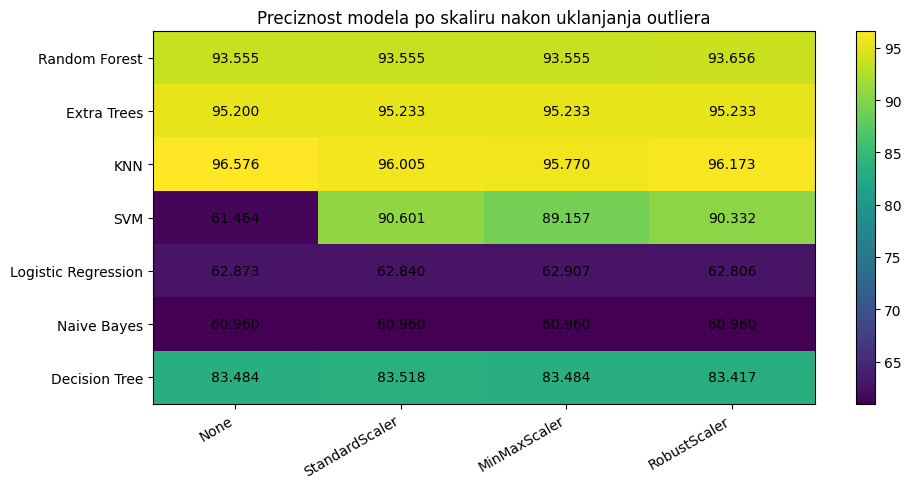

In [79]:
df_no_outliers = df[~zscore_mask]

print(df_no_outliers.shape)

y = df_no_outliers['eyeDetection']

X = df_no_outliers.drop(
    ['eyeDetection'],
    axis=1
)

X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scalers = {
    "None": [],
    "StandardScaler": [StandardScaler()],
    "MinMaxScaler": [MinMaxScaler()],
    "RobustScaler": [RobustScaler()],
}

acc_matrix2 = run_classifiers_matrix(X_train_no_outliers, y_train_no_outliers, X_test_no_outliers, y_test_no_outliers, scalers)
plot_matrix_heatmap(acc_matrix2, title="Preciznost modela po skaliru nakon uklanjanja outliera")

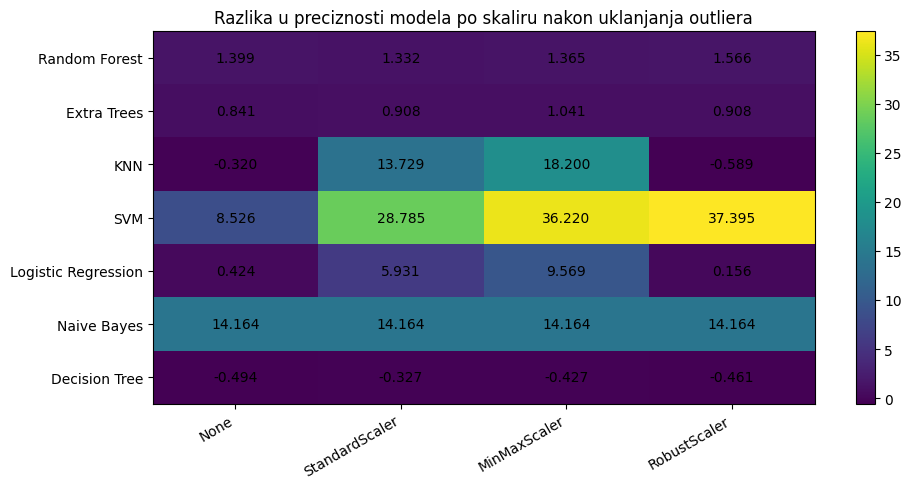

In [81]:
plot_matrix_heatmap(acc_matrix2 - acc_matrix1, title="Razlika u preciznosti modela po skaliru nakon uklanjanja outliera")

Iz matrice se može videti da je uglavnom došlo do poboljšanja preciznosti većine modela. Preciznost kod Decision Tree i KNN je malo opala, ali neuporedivo sa poboljšanjem ostalih.

### Balansiranje

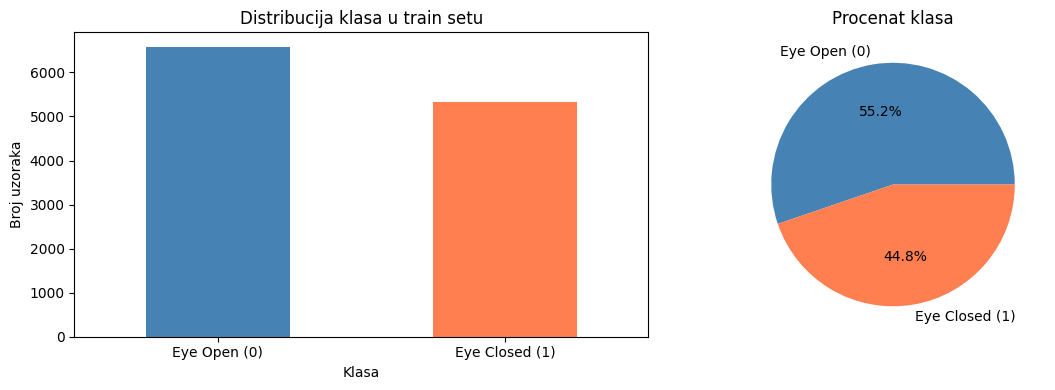

Imbalance ratio: 1.23:1


In [93]:
# Vizualizacija
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
y_train_no_outliers.value_counts().plot(kind='bar', ax=ax[0], color=['steelblue', 'coral'])
ax[0].set_title('Distribucija klasa u train setu')
ax[0].set_xlabel('Klasa')
ax[0].set_ylabel('Broj uzoraka')
ax[0].set_xticklabels(['Eye Open (0)', 'Eye Closed (1)'], rotation=0)

# Pie chart
y_train_no_outliers.value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                         labels=['Eye Open (0)', 'Eye Closed (1)'],
                                         colors=['steelblue', 'coral'])
ax[1].set_title('Procenat klasa')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

imbalance_ratio = y_train_no_outliers.value_counts().max() / y_train_no_outliers.value_counts().min()
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

#### Metode balansiranja

1. **Random Oversampling** - duplikacija manjinske klase
2. **Random Undersampling** - smanjenje većinske klase
3. **SMOTE** - generisanje sintetičkih uzoraka manjinske klase
4. **ADASYN** - adaptivno generisanje sintetičkih uzoraka
5. **SMOTETomek** - kombinacija SMOTE i Tomek links
6. **SMOTEENN** - kombinacija SMOTE i Edited Nearest Neighbours

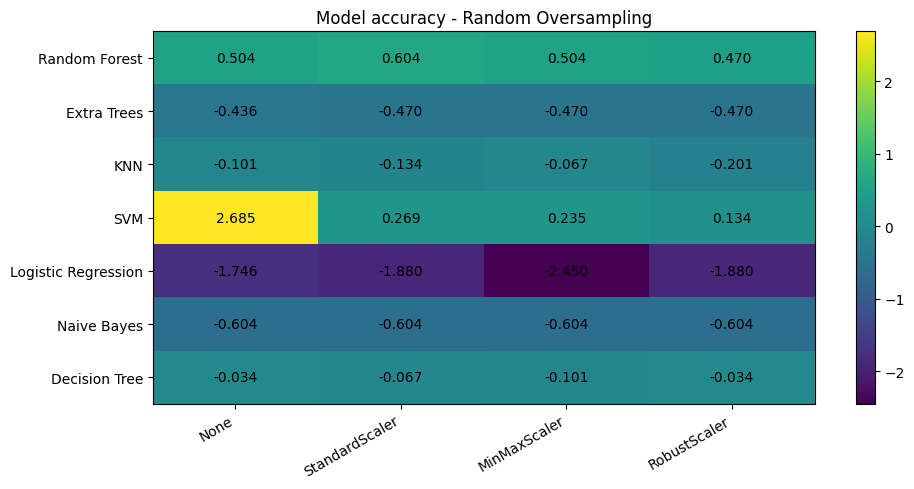

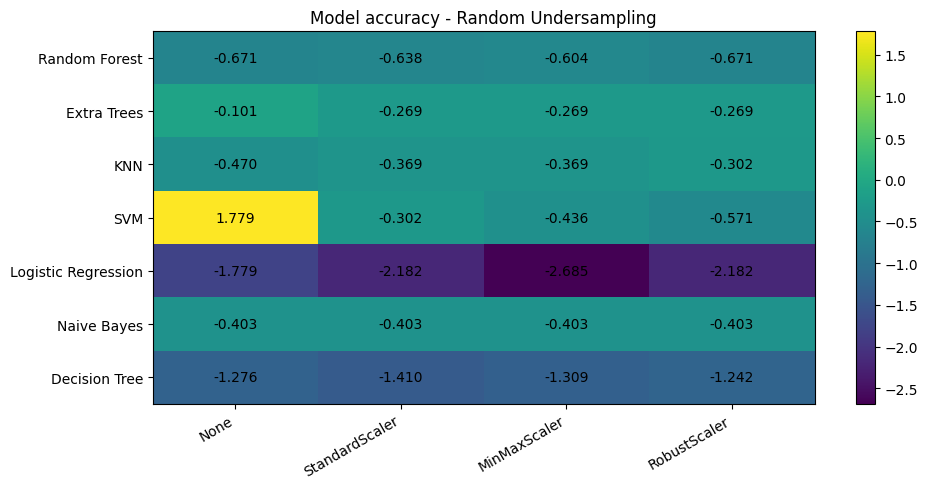

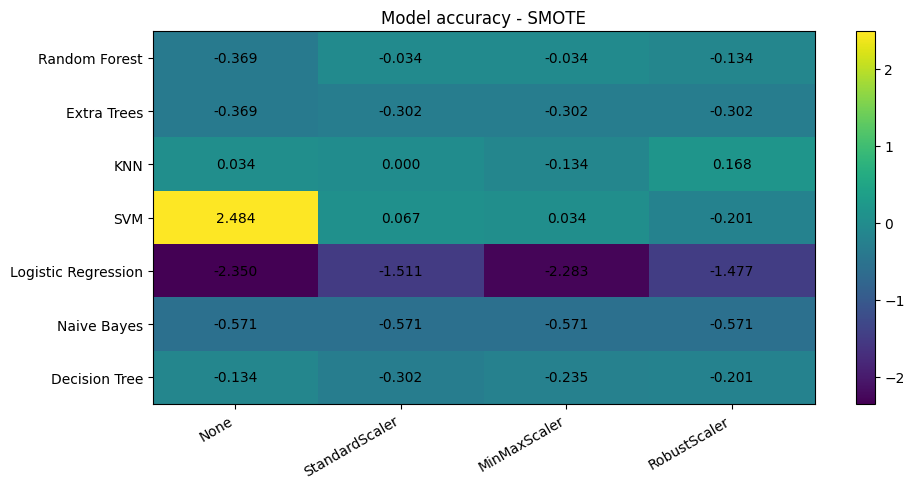

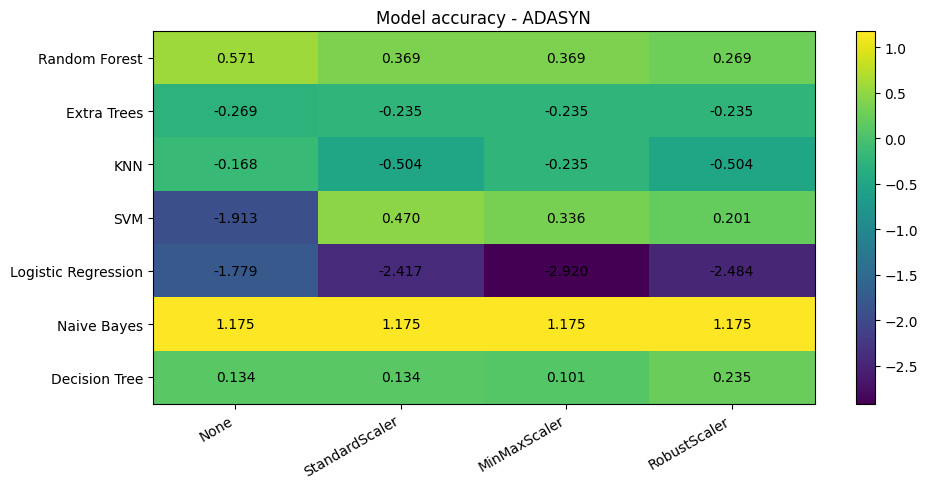

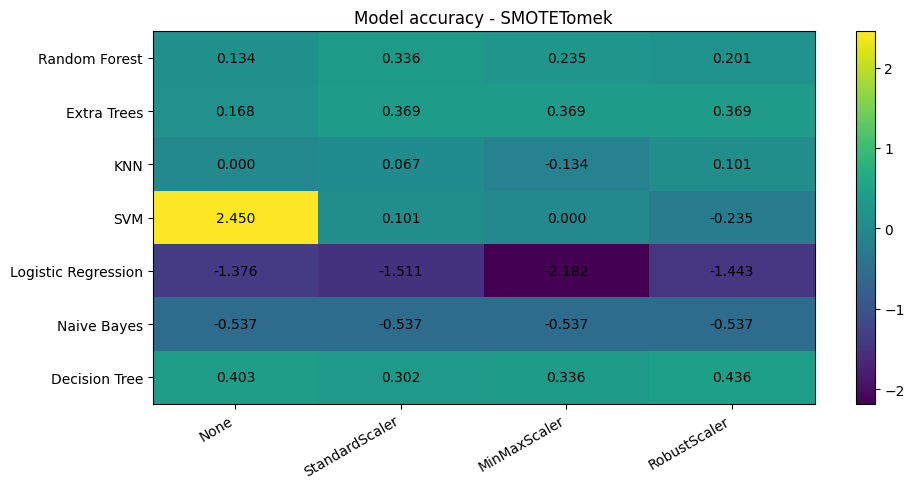

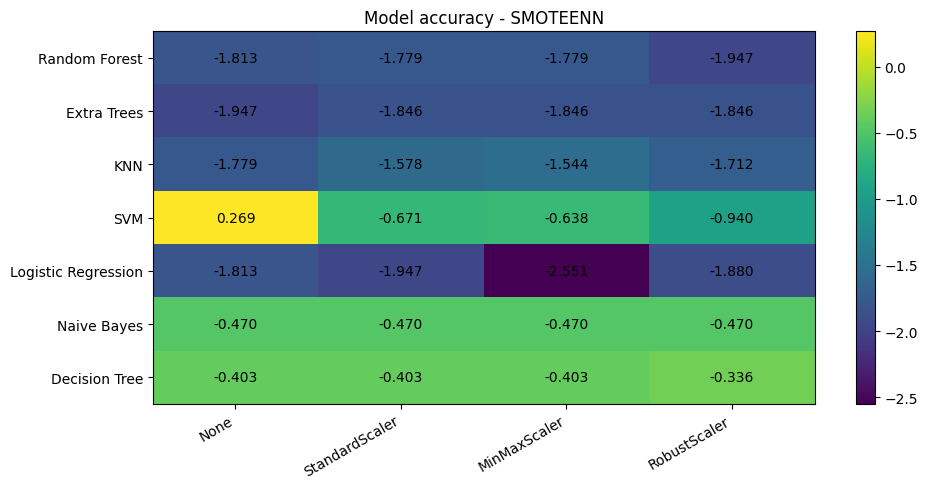

In [111]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

def evaluate_balancing_methods(X_train, y_train, X_test, y_test):
    balancing_methods = {
        "Random Oversampling": RandomOverSampler(random_state=42),
        "Random Undersampling": RandomUnderSampler(random_state=42),
        "SMOTE": SMOTE(random_state=42),
        "ADASYN": ADASYN(random_state=42),
        "SMOTETomek": SMOTETomek(random_state=42),
        "SMOTEENN": SMOTEENN(random_state=42)
    }
    
    results = []
    balanced_datasets = {}
    
    for method_name, sampler in balancing_methods.items():
        if sampler is None:
            X_train_balanced = X_train
            y_train_balanced = y_train
        else:
            X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)
        
        balanced_datasets[method_name] = (X_train_balanced, y_train_balanced)
        
        res = run_classifiers_matrix(X_train_balanced, y_train_balanced, X_test, y_test, scalers) - acc_matrix2
        
        plot_matrix_heatmap(res, title="Model accuracy - " + method_name)
        results.append({
            "Balancing Method": method_name,
            "Accuracy Matrix": res
        })
    
    return pd.DataFrame(results), balanced_datasets

balancing_results, balanced_datasets = evaluate_balancing_methods(
    X_train_no_outliers, 
    y_train_no_outliers, 
    X_test_no_outliers, 
    y_test_no_outliers
)

#### Analiza i preporuka najbolje metode balansiranja

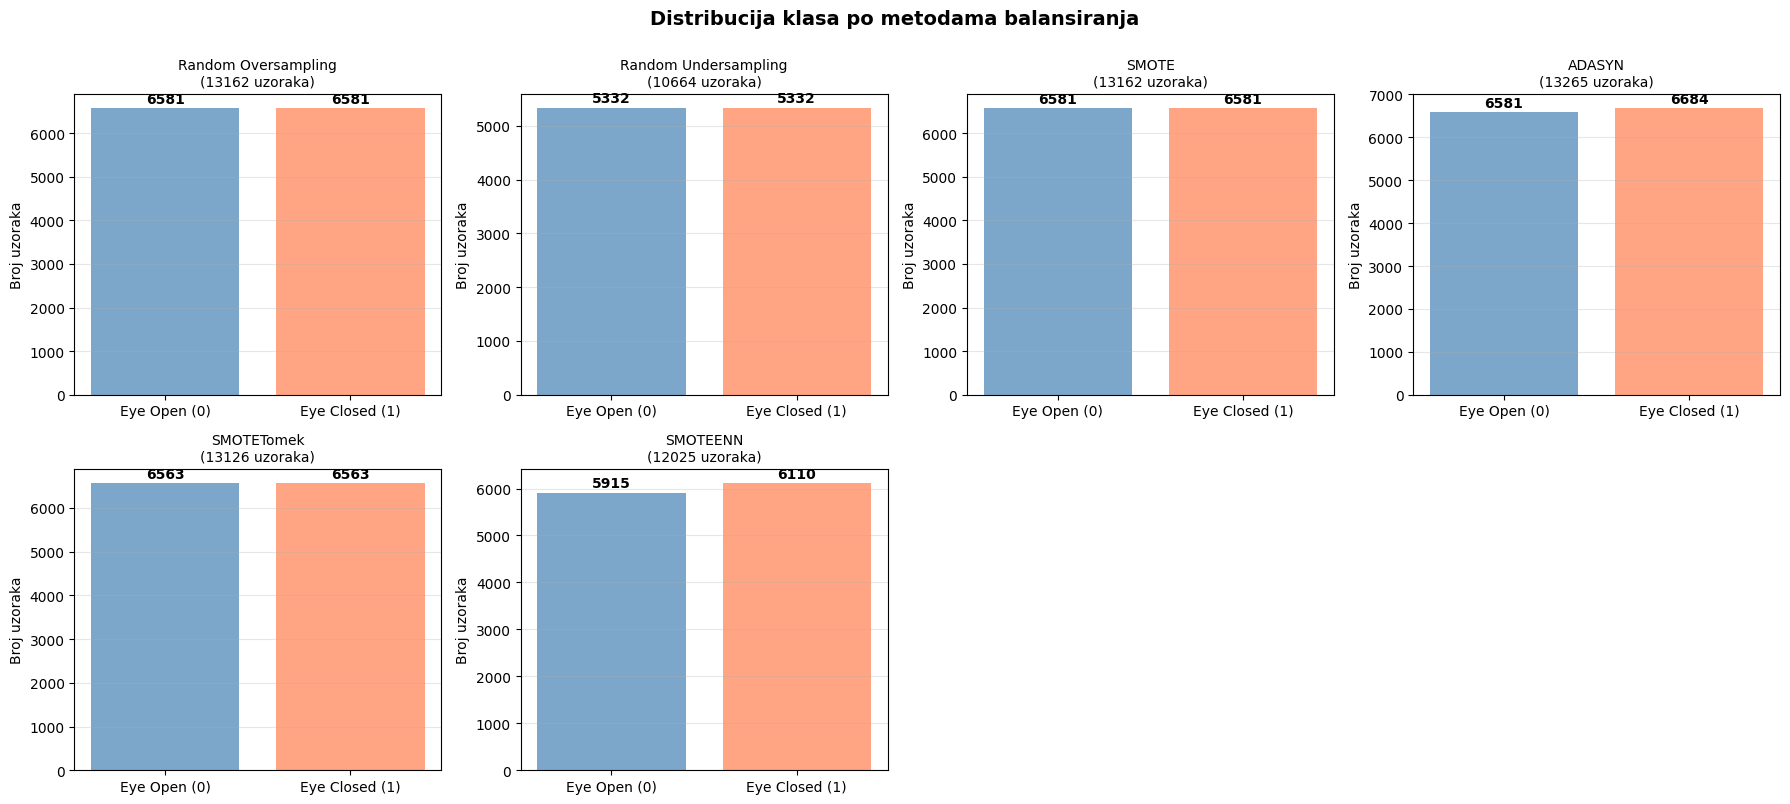

In [113]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.ravel()

for idx, (method_name, (X_bal, y_bal)) in enumerate(balanced_datasets.items()):
    if idx < len(axes):
        counts = pd.Series(y_bal).value_counts().sort_index()
        axes[idx].bar(['Eye Open (0)', 'Eye Closed (1)'], counts.values, 
                     color=['steelblue', 'coral'], alpha=0.7)
        axes[idx].set_title(f'{method_name}\n({counts.sum()} uzoraka)', fontsize=10)
        axes[idx].set_ylabel('Broj uzoraka')
        axes[idx].grid(axis='y', alpha=0.3)
        
        for i, v in enumerate(counts.values):
            axes[idx].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

for idx in range(len(balanced_datasets), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribucija klasa po metodama balansiranja', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

### 5.1 Definicija funkcija za evaluaciju

In [ ]:
def evaluate_all_models(X_train, X_test, y_train, y_test, step_name=""):
    models = {
        "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
        "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "SVM": SVC(kernel='rbf', random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
    }
    
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results.append({
            "Model": name,
            "Accuracy (%)": round(acc * 100, 2),
            "F1-Score (%)": round(f1 * 100, 2),
            "Step": step_name
        })
    
    return pd.DataFrame(results)

def plot_comparison(results_df, title="Poređenje modela"):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(results_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, results_df['Accuracy (%)'], width, label='Accuracy', color='steelblue')
    bars2 = ax.bar(x + width/2, results_df['F1-Score (%)'], width, label='F1-Score', color='coral')
    
    ax.set_xlabel('Model')
    ax.set_ylabel('Score (%)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 100)
    
    # Dodavanje vrednosti na barove
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

print("Funkcije za evaluaciju definisane.")

Funkcije za evaluaciju definisane.


### Uklanjanje visoko korelisanih feature-a

Na osnovu ranije analize korelacije, uklanjamo redundantne feature-e koji imaju korelaciju > 0.95.

In [ ]:
import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def get_high_corr_pairs(df: pd.DataFrame, threshold: float = 0.95):
    """
    Vrati listu (col_a, col_b, corr_value) za sve parove sa |corr| > threshold.
    """
    corr = df.corr().abs()
    cols = list(corr.columns)

    pairs = []
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            v = corr.iloc[i, j]
            if v > threshold:
                pairs.append((cols[i], cols[j], float(v)))
    return pairs

print(get_high_corr_pairs(X, threshold=0.95))

def generate_drop_sets_from_pairs(pairs):
    choices_per_pair = [(a, b) for a, b, _ in pairs]
    return list(itertools.product(*choices_per_pair))  

print(generate_drop_sets_from_pairs(get_high_corr_pairs(X, threshold=0.95)))

def evaluate_hight_corr_drops(X, y, drop_sets):
    results = []
    for drop_set in drop_sets:
        drop_set = list(set(drop_set))
        X_reduced = X.drop(columns=drop_set)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_reduced, y, test_size=0.2, random_state=42
        )
        res = evaluate_all_models(X_train,X_test, y_train, y_test, 'Korak 2, izbacivanje kolona')

        best_idx = res["Accuracy (%)"].idxmax()
        best_result = res.loc[best_idx]

        results.append({
            "Dropped Columns": drop_set,
            "Num Dropped": len(drop_set),
            "Best Classifier": best_result["Model"],
            "Accuracy (%)": best_result["Accuracy (%)"]
        })
    return pd.DataFrame(results)

evaluate_hight_corr_drops(X, y, generate_drop_sets_from_pairs(get_high_corr_pairs(X, threshold=0.95)))


[('AF3', 'P8', 0.9996066187213823), ('AF3', 'F8', 0.9987140947598644), ('FC5', 'O1', 0.9999610708874176), ('P7', 'AF4', 0.9883104382014991), ('P8', 'F8', 0.9988494382235333)]
[('AF3', 'AF3', 'FC5', 'P7', 'P8'), ('AF3', 'AF3', 'FC5', 'P7', 'F8'), ('AF3', 'AF3', 'FC5', 'AF4', 'P8'), ('AF3', 'AF3', 'FC5', 'AF4', 'F8'), ('AF3', 'AF3', 'O1', 'P7', 'P8'), ('AF3', 'AF3', 'O1', 'P7', 'F8'), ('AF3', 'AF3', 'O1', 'AF4', 'P8'), ('AF3', 'AF3', 'O1', 'AF4', 'F8'), ('AF3', 'F8', 'FC5', 'P7', 'P8'), ('AF3', 'F8', 'FC5', 'P7', 'F8'), ('AF3', 'F8', 'FC5', 'AF4', 'P8'), ('AF3', 'F8', 'FC5', 'AF4', 'F8'), ('AF3', 'F8', 'O1', 'P7', 'P8'), ('AF3', 'F8', 'O1', 'P7', 'F8'), ('AF3', 'F8', 'O1', 'AF4', 'P8'), ('AF3', 'F8', 'O1', 'AF4', 'F8'), ('P8', 'AF3', 'FC5', 'P7', 'P8'), ('P8', 'AF3', 'FC5', 'P7', 'F8'), ('P8', 'AF3', 'FC5', 'AF4', 'P8'), ('P8', 'AF3', 'FC5', 'AF4', 'F8'), ('P8', 'AF3', 'O1', 'P7', 'P8'), ('P8', 'AF3', 'O1', 'P7', 'F8'), ('P8', 'AF3', 'O1', 'AF4', 'P8'), ('P8', 'AF3', 'O1', 'AF4', 'F8'), 

Dropped Columns  Num Dropped Best Classifier  Accuracy (%)
0        [AF3, FC5, P7, P8]            4             KNN         93.93
1        [AF3, FC5, P7, F8]            4             KNN         92.49
2       [AF3, AF4, FC5, P8]            4             KNN         94.29
3       [AF3, AF4, FC5, F8]            4             KNN         92.32
4         [AF3, O1, P7, P8]            4             KNN         91.76
5         [AF3, O1, P7, F8]            4             KNN         90.09
6        [AF3, AF4, O1, P8]            4             KNN         92.46
7        [AF3, AF4, O1, F8]            4             KNN         90.25
8    [P8, F8, AF3, FC5, P7]            5             KNN         91.92
9        [AF3, FC5, P7, F8]            4             KNN         92.49
10  [P8, F8, AF3, FC5, AF4]            5             KNN         91.59
11      [AF3, AF4, FC5, F8]            4             KNN         92.32
12    [O1, P8, F8, AF3, P7]            5             KNN         88.99
13        [AF3, O1, P7, F8]            4             KNN         90.09
14   [O1, P8, F8, AF3, AF4]            5             KNN         89.69
15       [AF3, AF4, O1, F8]            4             KNN         90.25
16       [AF3, FC5, P7, P8]            4             KNN         93.93
17   [P8, F8, AF3, FC5, P7]            5             KNN         91.92
18      [AF3, AF4, FC5, P8]            4             KNN         94.29
19  [P8, F8, AF3, FC5, AF4]            5             KNN         91.59
20        [AF3, O1, P7, P8]            4             KNN         91.76
21    [O1, P8, F8, AF3, P7]            5             KNN         88.99
22       [AF3, AF4, O1, P8]            4             KNN         92.46
23   [O1, P8, F8, AF3, AF4]            5             KNN         89.69
24        [FC5, P7, P8, F8]            4             KNN         93.89
25        [FC5, P7, P8, F8]            4             KNN         93.89
26       [AF4, FC5, P8, F8]            4             KNN         94.23
27       [AF4, FC5, P8, F8]            4             KNN         94.23
28         [O1, P7, P8, F8]            4             KNN         90.99
29         [O1, P7, P8, F8]            4             KNN         90.99
30        [AF4, O1, P8, F8]            4             KNN         92.16
31        [AF4, O1, P8, F8]            4             KNN         92.16

In [ ]:
def evaluate_hight_corr_drops2(X, y, pairs, max_drop=5):
    all_corr_cols = set()
    for col_a, col_b, _ in pairs:
        all_corr_cols.add(col_a)
        all_corr_cols.add(col_b)
    
    all_corr_cols = list(all_corr_cols)
    
    results = []
    
    for num_to_drop in range(1, min(max_drop + 1, len(all_corr_cols) + 1)):
        combinations = itertools.combinations(all_corr_cols, num_to_drop)
        
        for drop_set in combinations:
            drop_set = list(drop_set)
            X_reduced = X.drop(columns=drop_set)
            
            X_train, X_test, y_train, y_test = train_test_split(
                X_reduced, y, test_size=0.2, random_state=42
            )
            
            res = evaluate_all_models(X_train, X_test, y_train, y_test, 'Izbacivanje kolona')
            
            best_idx = res["Accuracy (%)"].idxmax()
            best_result = res.loc[best_idx]

            results.append({
                "Dropped Columns": drop_set,
                "Num Dropped": len(drop_set),
                "Best Classifier": best_result["Model"],
                "Accuracy (%)": best_result["Accuracy (%)"],
                "Remaining Features": X_reduced.shape[1]
            })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="Accuracy (%)", ascending=False)
    
    return results_df

pairs = get_high_corr_pairs(X, threshold=0.95)
drop2_results = evaluate_hight_corr_drops2(X, y, pairs, max_drop=5)
print(f"Ukupno varijanti: {len(drop2_results)}")
print("\nTop 10 najboljih kombinacija:")
print(drop2_results.head(10).to_string(index=False))

Ukupno varijanti: 119

Top 10 najboljih kombinacija:
Dropped Columns  Num Dropped Best Classifier  Accuracy (%)  Remaining Features
           [P8]            1             KNN         96.86                  13
          [AF4]            1             KNN         96.70                  13
      [P8, AF4]            2             KNN         96.70                  12
      [P8, FC5]            2             KNN         96.66                  12
          [AF3]            1             KNN         96.43                  13
          [FC5]            1             KNN         96.40                  13
           [P7]            1             KNN         96.30                  13
      [P8, AF3]            2             KNN         96.23                  12
           [F8]            1             KNN         96.19                  13
       [P8, P7]            2             KNN         96.19                  12


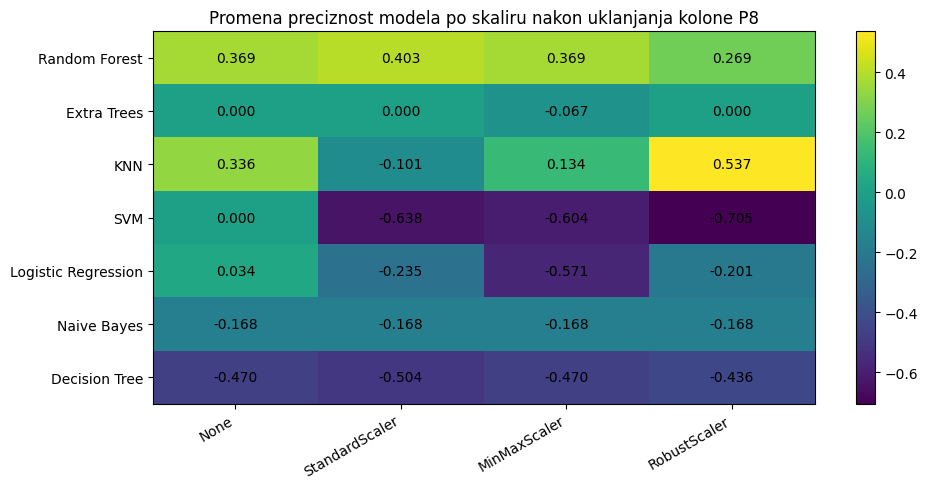

In [126]:
X_train_no_P8 = X_train_no_outliers.drop(columns=['P8'])
X_test_no_P8 = X_test_no_outliers.drop(columns=['P8'])

y_train_no_P8 = y_train_no_outliers
y_test_no_P8 = y_test_no_outliers

acc_matrix3 = run_classifiers_matrix(X_train_no_P8, y_train_no_P8, X_test_no_P8, y_test_no_P8, scalers)
plot_matrix_heatmap(acc_matrix3 - acc_matrix2, title="Promena preciznost modela po skaliru nakon uklanjanja kolone P8")

### Redukcija dimenzionalnosti (PCA)

Primenjujemo PCA (Principal Component Analysis) za redukciju dimenzionalnosti sa zadržavanjem 95% varijanse.

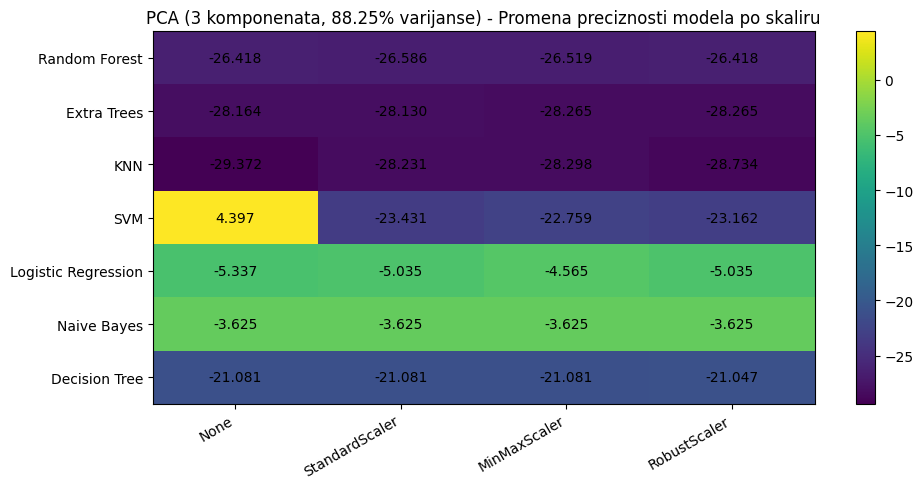

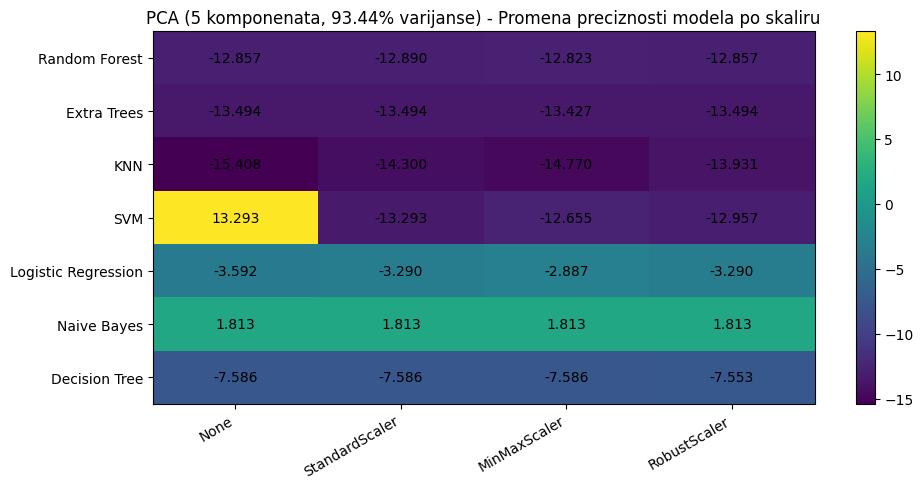

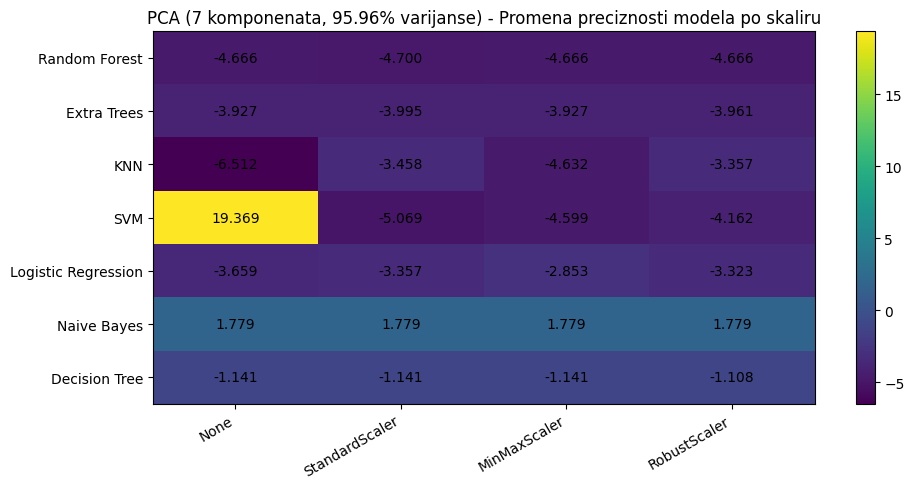

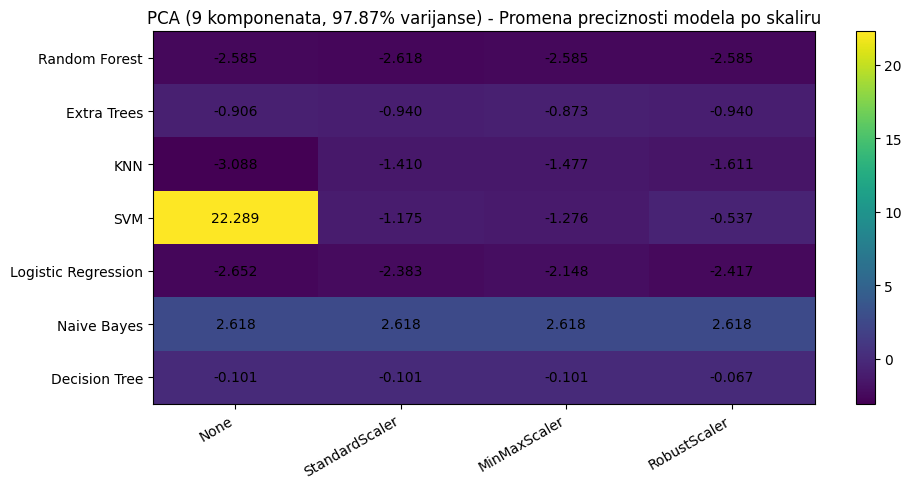

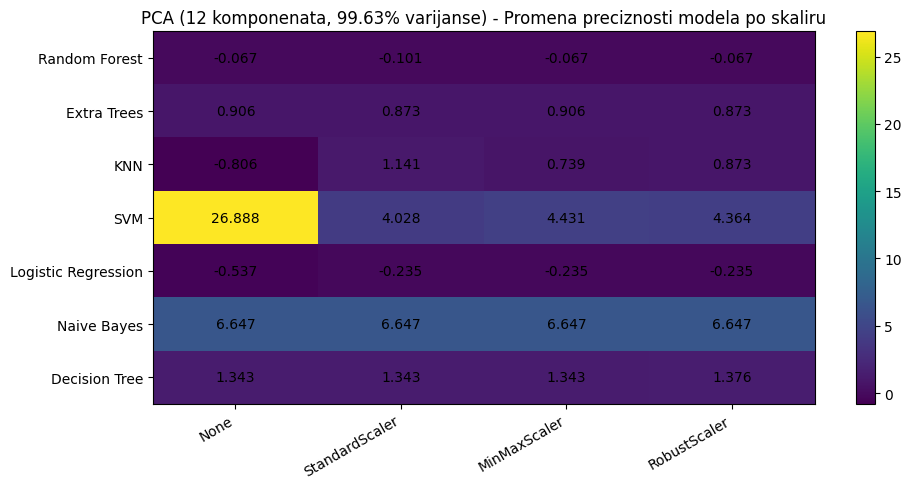

In [ ]:
pca_results = []

for n_components in [3, 5, 7, 9, 12]:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_no_P8)
    X_test_pca = pca.transform(X_test_no_P8)
    
    explained_var = sum(pca.explained_variance_ratio_) * 100

    res = run_classifiers_matrix(X_train_pca, y_train_no_P8, X_test_pca, y_test_no_P8, scalers)

    plot_matrix_heatmap(res - acc_matrix3, title=f"PCA ({n_components} komponenata, {explained_var:.2f}% varijanse) - Promena preciznosti modela po skaliru")

    pca_results.append({
        "n_components": n_components,
        "explained_variance": explained_var,
        "accuracy": res * 100
    })

### Optimizacija hiperparametara

In [134]:
print("\n--- Random Forest optimizacija ---")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = RandomizedSearchCV(rf, rf_param_grid, n_iter=20, cv=5, scoring='accuracy', 
                              random_state=42, n_jobs=-1, verbose=1)
rf_grid.fit(X_train_no_P8, y_train_no_P8)

print(f"Najbolji parametri: {rf_grid.best_params_}")
print(f"Najbolja CV tačnost: {rf_grid.best_score_*100:.2f}%")

rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test_no_P8)
print(f"Test tačnost: {accuracy_score(y_test_no_P8, rf_pred)*100:.2f}%")


--- Random Forest optimizacija ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L3Zhci9mb2xkZXJzL3ZoLzFkOTVfX3B4MnJuZzd5MXFzd256a3BkYzAwMDBnbi9UL2pvYmxpYl9tZW1tYXBwaW5nX2ZvbGRlcl8yMTU5OV83ZTE2OWE0ZjE2OGQ0ODJhYjY1Zjk5MTRmYmVhZTRkZl9hNzdjNGVhNjJjMzY0MTgxYjY0M2UyNzczOWRlZTIzNw=="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"semlock","base64_name" for automat

Najbolji parametri: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Najbolja CV tačnost: 92.48%
Test tačnost: 93.89%


In [136]:
# Extra Trees optimizacija
print("\n--- Extra Trees optimizacija ---")
et_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

et = ExtraTreesClassifier(random_state=42, n_jobs=-1)
et_grid = RandomizedSearchCV(et, et_param_grid, n_iter=20, cv=5, scoring='accuracy', 
                              random_state=42, n_jobs=-1, verbose=1)
et_grid.fit(X_train_no_P8, y_train_no_P8)

print(f"Najbolji parametri: {et_grid.best_params_}")
print(f"Najbolja CV tačnost: {et_grid.best_score_*100:.2f}%")

et_best = et_grid.best_estimator_
et_pred = et_best.predict(X_test_no_P8)
print(f"Test tačnost: {accuracy_score(y_test_no_P8, et_pred)*100:.2f}%")


--- Extra Trees optimizacija ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L3Zhci9mb2xkZXJzL3ZoLzFkOTVfX3B4MnJuZzd5MXFzd256a3BkYzAwMDBnbi9UL2pvYmxpYl9tZW1tYXBwaW5nX2ZvbGRlcl8yMTU5OV85MTMzNzY5MTQ1NDE0NWZiOGNkOGY5MDFlNzk4NjM1Yl9lMGI4NThiZWFiZjQ0ZGI3OGM4ODJiMzE1NjRkMzFiZQ=="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic 

Najbolji parametri: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}
Najbolja CV tačnost: 94.38%
Test tačnost: 95.47%


In [ ]:
# KNN optimizacija
print("\n--- KNN optimizacija ---")
knn_param_grid = {
    'n_neighbors': range(1, 300, 2) ,
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
knn_grid.fit(X_train_no_P8, y_train_no_P8)

print(f"Najbolji parametri: {knn_grid.best_params_}")
print(f"Najbolja CV tačnost: {knn_grid.best_score_*100:.2f}%")

knn_best = knn_grid.best_estimator_
knn_pred = knn_best.predict(X_test_no_P8)
print(f"Test tačnost: {accuracy_score(y_test_no_P8, knn_pred)*100:.2f}%")



--- KNN optimizacija ---
Fitting 5 folds for each of 900 candidates, totalling 4500 fits


Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L3Zhci9mb2xkZXJzL3ZoLzFkOTVfX3B4MnJuZzd5MXFzd256a3BkYzAwMDBnbi9UL2pvYmxpYl9tZW1tYXBwaW5nX2ZvbGRlcl8yMTU5OV9hZmIxZTYyNzc4OGU0Y2UyYjFiNGU5ZmNmNWU0OTk4Zl85MDEzN2U1ZWE5YmQ0ZTY0ODcxYjAzZTFhYTE2ZDdkMw=="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic 

In [1]:
# SVM optimizacija
print("\n--- SVM optimizacija ---")
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}

svm = SVC(random_state=42)
svm_grid = RandomizedSearchCV(svm, svm_param_grid, n_iter=15, cv=5, scoring='accuracy', 
                               random_state=42, n_jobs=-1, verbose=1)
svm_grid.fit(X_train_no_P8, y_train_no_P8)

print(f"Najbolji parametri: {svm_grid.best_params_}")
print(f"Najbolja CV tačnost: {svm_grid.best_score_*100:.2f}%")

svm_best = svm_grid.best_estimator_
svm_pred = svm_best.predict(X_test_no_P8)
print(f"Test tačnost: {accuracy_score(y_test_no_P8, svm_pred)*100:.2f}%")


--- SVM optimizacija ---


NameError: name 'SVC' is not defined


Rezultati nakon optimizacije hiperparametara
              Model  Accuracy (%)  F1-Score (%)         Step
Random Forest (opt)         93.22         93.21 Optimizovano
  Extra Trees (opt)         94.86         94.85 Optimizovano
          KNN (opt)         91.22         91.21 Optimizovano
          SVM (opt)         83.44         83.27 Optimizovano


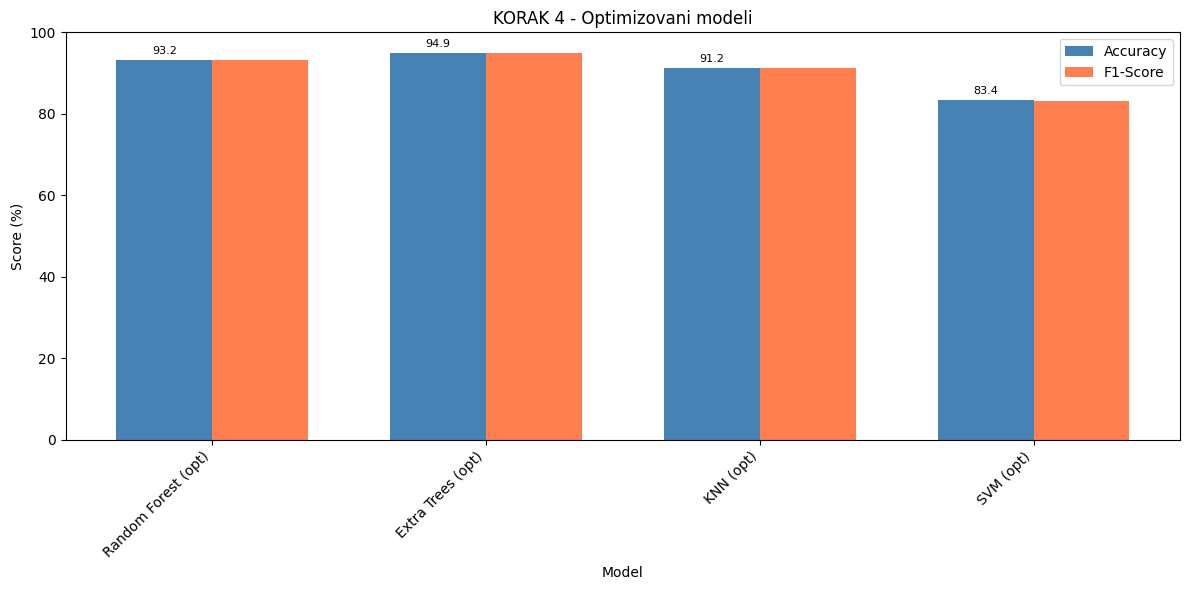

In [ ]:
# Sumarni rezultati nakon optimizacije hiperparametara
print("\n" + "=" * 60)
print("Rezultati nakon optimizacije hiperparametara")
print("=" * 60)

optimized_results = pd.DataFrame([
    {"Model": "Random Forest (opt)", "Accuracy (%)": round(accuracy_score(y_test, rf_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test, rf_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
    {"Model": "Extra Trees (opt)", "Accuracy (%)": round(accuracy_score(y_test, et_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test, et_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
    {"Model": "KNN (opt)", "Accuracy (%)": round(accuracy_score(y_test, knn_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test, knn_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
    {"Model": "SVM (opt)", "Accuracy (%)": round(accuracy_score(y_test, svm_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test, svm_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
])

print(optimized_results.to_string(index=False))
plot_comparison(optimized_results, "KORAK 4 - Optimizovani modeli")

all_results.append(optimized_results.copy())

## 6. Analiza interpretabilnosti modela

U ovom delu analiziramo interpretabilnost modela koristeći:
- **Feature Importance** - značaj feature-a u tree-based modelima
- **SHAP vrednosti** - SHapley Additive exPlanations
- **LIME** - Local Interpretable Model-agnostic Explanations

### 6.1 Feature Importance (Random Forest & Extra Trees)

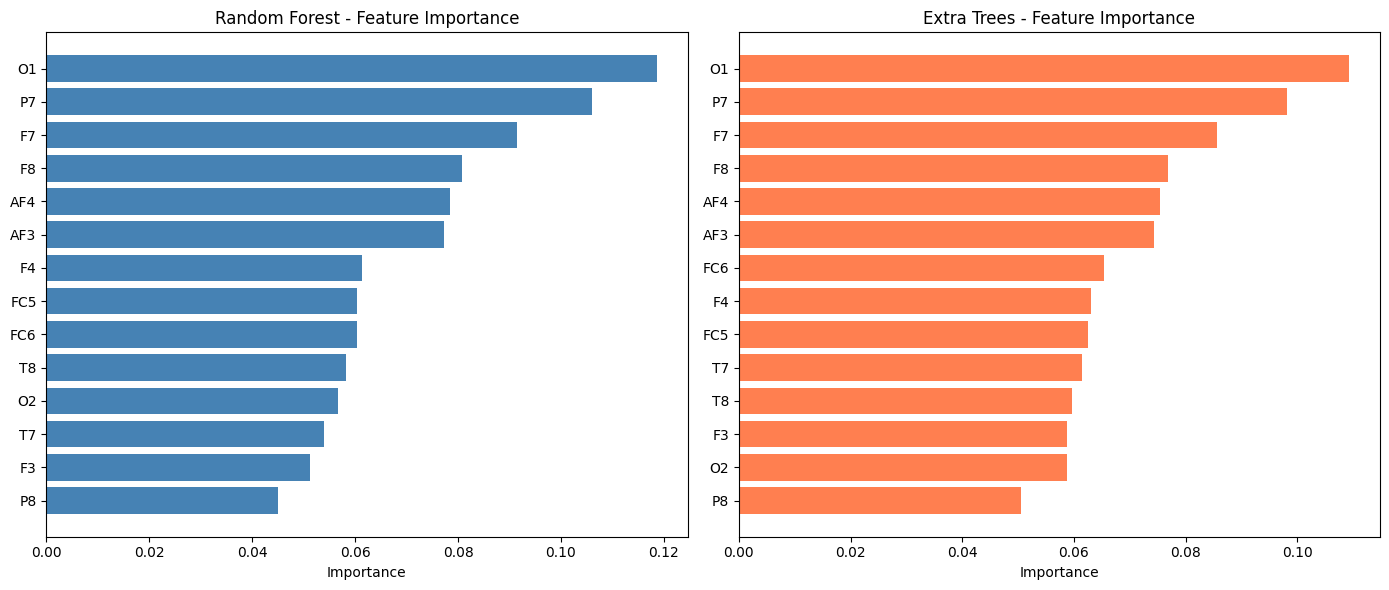


Top 5 najvažnijih feature-a (Random Forest):
Feature  Importance
     O1    0.118659
     P7    0.106063
     F7    0.091444
     F8    0.080860
    AF4    0.078503

Top 5 najvažnijih feature-a (Extra Trees):
Feature  Importance
     O1    0.109358
     P7    0.098150
     F7    0.085555
     F8    0.076801
    AF4    0.075481


In [ ]:
# Feature Importance analiza
feature_names = X.columns.tolist()

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

# Extra Trees Feature Importance
et_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': et_best.feature_importances_
}).sort_values('Importance', ascending=False)

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].barh(rf_importance['Feature'], rf_importance['Importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Feature Importance')
axes[0].invert_yaxis()

# Extra Trees
axes[1].barh(et_importance['Feature'], et_importance['Importance'], color='coral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Extra Trees - Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 5 najvažnijih feature-a (Random Forest):")
print(rf_importance.head().to_string(index=False))
print("\nTop 5 najvažnijih feature-a (Extra Trees):")
print(et_importance.head().to_string(index=False))

### SHAP Analiza (SHapley Additive exPlanations)

SHAP vrednosti pokazuju doprinos svakog feature-a predikciji modela.

### LIME Analiza (Local Interpretable Model-agnostic Explanations)

LIME objašnjava pojedinačne predikcije kreirajući lokalni interpretabilan model.